In [3]:
!pip install transformers datasets peft

In [4]:
!pip install scikit-learn

In [5]:
!pip install seaborn

In [6]:
!pip install transformers datasets peft accelerate


In [ ]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("facebook/empathetic_dialogues")

# Function to clean the data
def preprocess(example):
    # Replace "_comma_" with ", " in the utterance column
    if example["utterance"] is not None:  # Check for null values
        example["utterance"] = example["utterance"].replace("_comma_", ",")
        example["prompt"] = example["prompt"].replace("_comma_", ",")
    return example

# Apply preprocessing
dataset = dataset.map(preprocess)

# Function to remove null values
def remove_null(example):
    return example["utterance"] is not None  # Keep only non-null utterances

# Apply filtering to remove null values
dataset = dataset.filter(remove_null)

# Display an example after preprocessing
print(dataset["train"][0:8])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.15k [00:00<?, ?B/s]

empathetic_dialogues.py:   0%|          | 0.00/4.51k [00:00<?, ?B/s]

The repository for facebook/empathetic_dialogues contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/facebook/empathetic_dialogues.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/76673 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/12030 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10943 [00:00<?, ? examples/s]

Map:   0%|          | 0/76673 [00:00<?, ? examples/s]

Map:   0%|          | 0/12030 [00:00<?, ? examples/s]

Map:   0%|          | 0/10943 [00:00<?, ? examples/s]

Filter:   0%|          | 0/76673 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12030 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10943 [00:00<?, ? examples/s]

{'conv_id': ['hit:0_conv:1', 'hit:0_conv:1', 'hit:0_conv:1', 'hit:0_conv:1', 'hit:0_conv:1', 'hit:0_conv:1', 'hit:1_conv:2', 'hit:1_conv:2'], 'utterance_idx': [1, 2, 3, 4, 5, 6, 1, 2], 'context': ['sentimental', 'sentimental', 'sentimental', 'sentimental', 'sentimental', 'sentimental', 'afraid', 'afraid'], 'prompt': ['I remember going to the fireworks with my best friend. There was a lot of people, but it only felt like us in the world.', 'I remember going to the fireworks with my best friend. There was a lot of people, but it only felt like us in the world.', 'I remember going to the fireworks with my best friend. There was a lot of people, but it only felt like us in the world.', 'I remember going to the fireworks with my best friend. There was a lot of people, but it only felt like us in the world.', 'I remember going to the fireworks with my best friend. There was a lot of people, but it only felt like us in the world.', 'I remember going to the fireworks with my best friend. There

In [ ]:
from datasets import load_dataset
import pandas as pd

# Convert train and test splits to Pandas DataFrames
df_train = dataset["train"].to_pandas()
df_test = dataset["test"].to_pandas()

# Display the first few rows
print(df_train.head())
print(df_train.columns)  # Check column names

        conv_id  utterance_idx      context  \
0  hit:0_conv:1              1  sentimental   
1  hit:0_conv:1              2  sentimental   
2  hit:0_conv:1              3  sentimental   
3  hit:0_conv:1              4  sentimental   
4  hit:0_conv:1              5  sentimental   

                                              prompt  speaker_idx  \
0  I remember going to the fireworks with my best...            1   
1  I remember going to the fireworks with my best...            0   
2  I remember going to the fireworks with my best...            1   
3  I remember going to the fireworks with my best...            0   
4  I remember going to the fireworks with my best...            1   

                                           utterance     selfeval tags  
0  I remember going to see the fireworks with my ...  5|5|5_2|2|5       
1  Was this a friend you were in love with, or ju...  5|5|5_2|2|5       
2                This was a best friend. I miss her.  5|5|5_2|2|5       
3         

In [ ]:
# Keep only rows that DO NOT contain "_conv:" in the utterances column
df_train = df_train[~df_train['utterance'].str.contains('_conv:')]
df_test = df_test[~df_test['utterance'].str.contains('_conv:')]
#df_train.reset_index(drop=True, inplace=True)


In [ ]:
# Check if any rows still have '_conv:'
df_train[df_train['utterance'].str.contains('_conv:')]
df_test[df_test['utterance'].str.contains('_conv:')]

,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags


In [ ]:
df_train.to_csv('check.csv', index=False)


In [ ]:
from google.colab import files
files.download('check.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd

# Assuming your dataframe is named df
# Step 1: Drop the 'selfeval' and 'tags' columns
df_train = df_train.drop(columns=['selfeval', 'tags'])
df_test = df_test.drop(columns=['selfeval', 'tags'])

def group_conversations(df):
    """
    Groups conversation data by 'conv_id'.

    Args:
        df (pd.DataFrame): Original dataframe containing conv_id, prompt, context, utterance_idx, and utterance.

    Returns:
        pd.DataFrame: Grouped dataframe with combined utterances and representative prompt/context.
    """
    grouped_df = (
        df.groupby('conv_id')
        .apply(lambda x: pd.Series({
            'prompt': x['prompt'].iloc[0],  # Take the first prompt
            'context': x['context'].iloc[0],  # Take the first context
            'utterances': ' '.join(x.sort_values('utterance_idx')['utterance'].astype(str))  # Combine utterances
        }))
        .reset_index()
    )
    return grouped_df

grouped_df_train = group_conversations(df_train)
grouped_df_test = group_conversations(df_test)

print(grouped_df_train.head())
print(grouped_df_test.head())



<ipython-input-15-17cba304addc>:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


                conv_id                                             prompt  \
0          hit:0_conv:1  I remember going to the fireworks with my best...   
1  hit:10000_conv:20000  My girlfriend got me a toad today! I was so sh...   
2  hit:10000_conv:20001       I really like the new paint job on my house.   
3  hit:10001_conv:20002  I went to the skating rink all by myself today...   
4  hit:10002_conv:20004  I was walking on the road. I saw beggar and i ...   

       context                                         utterances  
0  sentimental  I remember going to see the fireworks with my ...  
1    surprised  My girlfriend got me a pet toad today! Do you ...  
2    impressed  I really like the new paint job on my house. T...  
3       lonely  I went to the skating rink all by myself today...  
4      ashamed  I was walking on the road. I saw a beggar and ...  
                conv_id                                             prompt  \
0          hit:0_conv:0  I felt guilty when I

<ipython-input-15-17cba304addc>:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


In [ ]:
label_counts_train = grouped_df_train["context"].value_counts()
label_counts_test = grouped_df_test["context"].value_counts()
print(label_counts_train)
print(grouped_df_train.shape)
print(label_counts_test)
print(grouped_df_test.shape)

context
surprised       924
excited         683
angry           636
proud           636
annoyed         613
sad             609
grateful        586
lonely          585
afraid          584
terrified       578
guilty          571
anxious         571
disgusted       569
confident       566
hopeful         564
impressed       561
anticipating    561
furious         553
joyful          552
disappointed    549
nostalgic       542
prepared        536
jealous         535
content         516
devastated      514
embarrassed     511
caring          474
sentimental     473
trusting        453
ashamed         445
apprehensive    418
faithful        325
Name: count, dtype: int64
(17793, 4)
context
surprised       127
proud            96
grateful         95
sentimental      91
excited          91
annoyed          91
sad              88
disgusted        86
angry            84
joyful           83
embarrassed      81
jealous          81
impressed        81
disappointed     81
caring           80
hopeful

In [ ]:
from transformers import pipeline
emotion_classifier = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    truncation=True,
    max_length=512,
    top_k=None    # updated from return_all_scores=True
)

def get_emotion_score(text):
    predictions = emotion_classifier(text)[0]
    max_prob = max([pred['score'] for pred in predictions])
    return round(max_prob * 10, 2)


#df_small['sentiment_score'] = df_small['utterances'].apply(get_emotion_score)
grouped_df_train['sentiment_score'] = grouped_df_train['utterances'].apply(get_emotion_score)
grouped_df_train.head()
#df_small.head()

#grouped_df_test['sentiment_score'] = grouped_df_test['utterances'].apply(get_emotion_score)
#grouped_df_test.head()

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
grouped_df_train.to_csv('grouped_df_train_with_scores.csv', index=False)


In [ ]:
from google.colab import files
files.download('grouped_df_train_with_scores.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
grouped_df_train.to_excel('grouped_df_train_with_scores.xlsx', index=False)


In [ ]:
from google.colab import files
files.download('grouped_df_train_with_scores.xlsx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Example path - you can customize this path to a folder inside your Google Drive
!cp grouped_df_train_with_scores.csv /content/drive/MyDrive/research


In [ ]:
# Example path - you can customize this path to a folder inside your Google Drive
!cp grouped_df_train_with_scores.xlsx /content/drive/MyDrive/research

In [ ]:
grouped_df_test['sentiment_score'] = grouped_df_test['utterances'].apply(get_emotion_score)
grouped_df_test.head()

,conv_id,prompt,context,utterances,sentiment_score
0,hit:0_conv:0,I felt guilty when I was driving home one nigh...,guilty,Yeah about 10 years ago I had a horrifying exp...,8.91
1,hit:10025_conv:20050,I was in for a treat the other day when my hus...,surprised,"I got something nice the other day, chocolates...",9.33
2,hit:10036_conv:20072,I have problems with the city and their consta...,trusting,I have problems with the city and their consta...,7.62
3,hit:10039_conv:20079,Everyday i wake up and see my girlfriends beau...,faithful,"I always do the same, it's not had when they a...",9.66
4,hit:10040_conv:20080,"I close on my new house Monday, I didn't think...",trusting,"I close on my new house Monday, I didn't think...",7.65


In [ ]:
grouped_df_test.to_csv('grouped_df_test_with_scores.csv', index=False)
grouped_df_test.to_excel('grouped_df_test_with_scores.xlsx', index=False)

In [ ]:
files.download('grouped_df_test_with_scores.csv')
files.download('grouped_df_test_with_scores.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Example path - you can customize this path to a folder inside your Google Drive
!cp grouped_df_test_with_scores.csv /content/drive/MyDrive/research

In [ ]:
# Example path - you can customize this path to a folder inside your Google Drive
!cp grouped_df_test_with_scores.xlsx /content/drive/MyDrive/research

In [7]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Replace with your actual file path
file_path_train = '/content/drive/MyDrive/research/grouped_df_train_with_scores.csv'
file_path_test = '/content/drive/MyDrive/research/grouped_df_test_with_scores.csv'

# Load the dataset
grouped_df_train = pd.read_csv(file_path_train)
grouped_df_test = pd.read_csv(file_path_test)

# Preview
grouped_df_train.head()
grouped_df_test.head()


Mounted at /content/drive


,conv_id,prompt,context,utterances,sentiment_score
0,hit:0_conv:0,I felt guilty when I was driving home one nigh...,guilty,Yeah about 10 years ago I had a horrifying exp...,8.91
1,hit:10025_conv:20050,I was in for a treat the other day when my hus...,surprised,"I got something nice the other day, chocolates...",9.33
2,hit:10036_conv:20072,I have problems with the city and their consta...,trusting,I have problems with the city and their consta...,7.62
3,hit:10039_conv:20079,Everyday i wake up and see my girlfriends beau...,faithful,"I always do the same, it's not had when they a...",9.66
4,hit:10040_conv:20080,"I close on my new house Monday, I didn't think...",trusting,"I close on my new house Monday, I didn't think...",7.65


In [8]:
grouped_df_train.head()

,conv_id,prompt,context,utterances,sentiment_score
0,hit:0_conv:1,I remember going to the fireworks with my best...,sentimental,I remember going to see the fireworks with my ...,4.11
1,hit:10000_conv:20000,My girlfriend got me a toad today! I was so sh...,surprised,My girlfriend got me a pet toad today! Do you ...,9.61
2,hit:10000_conv:20001,I really like the new paint job on my house.,impressed,I really like the new paint job on my house. T...,9.82
3,hit:10001_conv:20002,I went to the skating rink all by myself today...,lonely,I went to the skating rink all by myself today...,8.29
4,hit:10002_conv:20004,I was walking on the road. I saw beggar and i ...,ashamed,I was walking on the road. I saw a beggar and ...,5.43


In [9]:
label_counts_train = grouped_df_train["context"].value_counts()
label_counts_test = grouped_df_test["context"].value_counts()
print(grouped_df_train.shape)
print(grouped_df_test.shape)

(17793, 5)
(2540, 5)


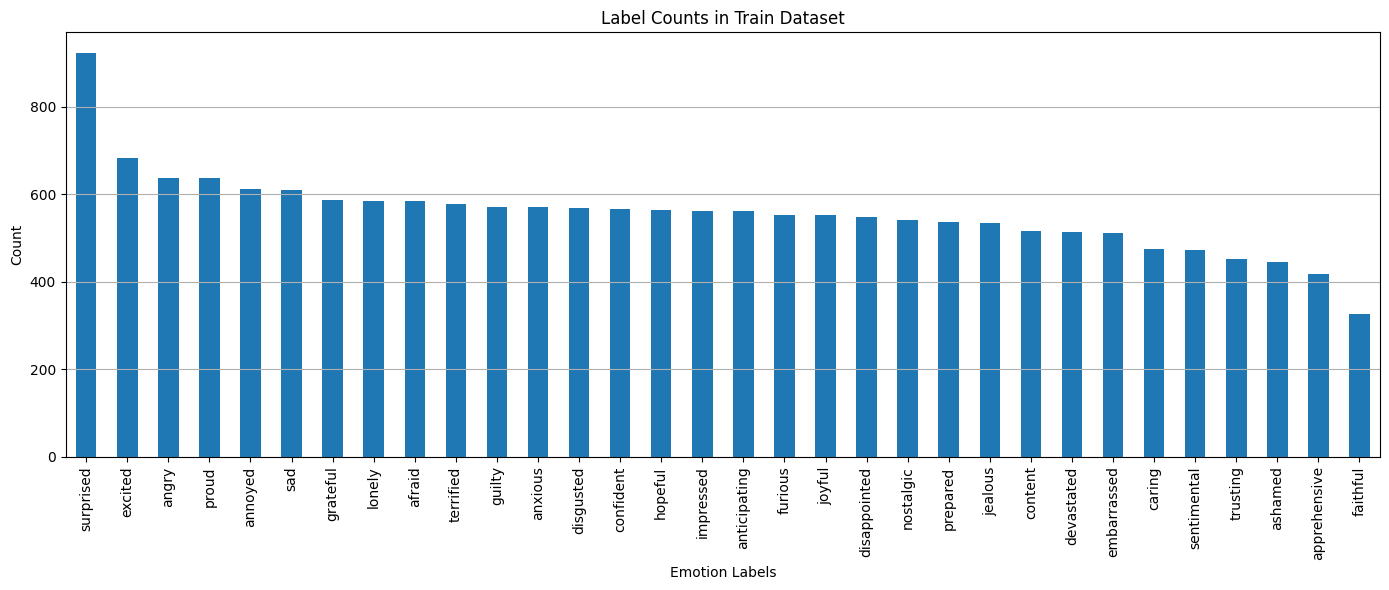

In [10]:
import matplotlib.pyplot as plt

# Get the label counts
label_counts_train = grouped_df_train["context"].value_counts()

# Plot the bar chart
plt.figure(figsize=(14, 6))
label_counts_train.plot(kind='bar')
plt.xlabel("Emotion Labels")
plt.ylabel("Count")
plt.title("Label Counts in Train Dataset")
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(axis='y')

plt.show()


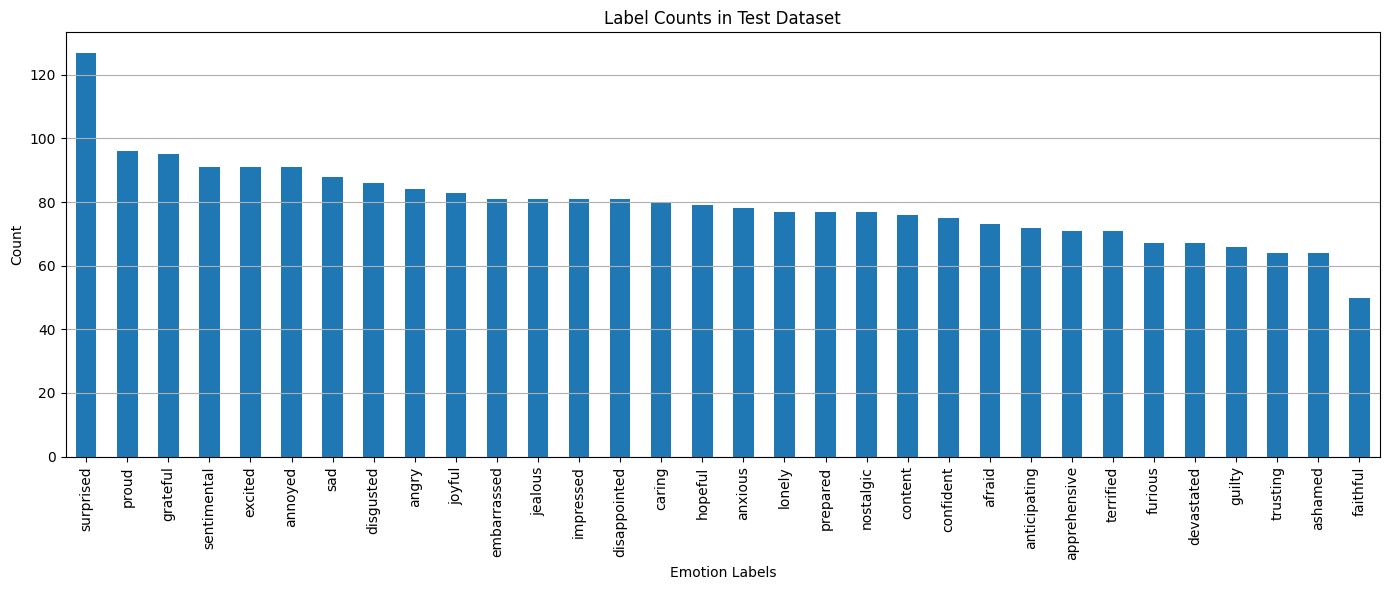

In [11]:
import matplotlib.pyplot as plt

# Get the label counts
label_counts_test = grouped_df_test["context"].value_counts()

# Plot the bar chart
plt.figure(figsize=(14, 6))
label_counts_test.plot(kind='bar')
plt.xlabel("Emotion Labels")
plt.ylabel("Count")
plt.title("Label Counts in Test Dataset")
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(axis='y')

plt.show()


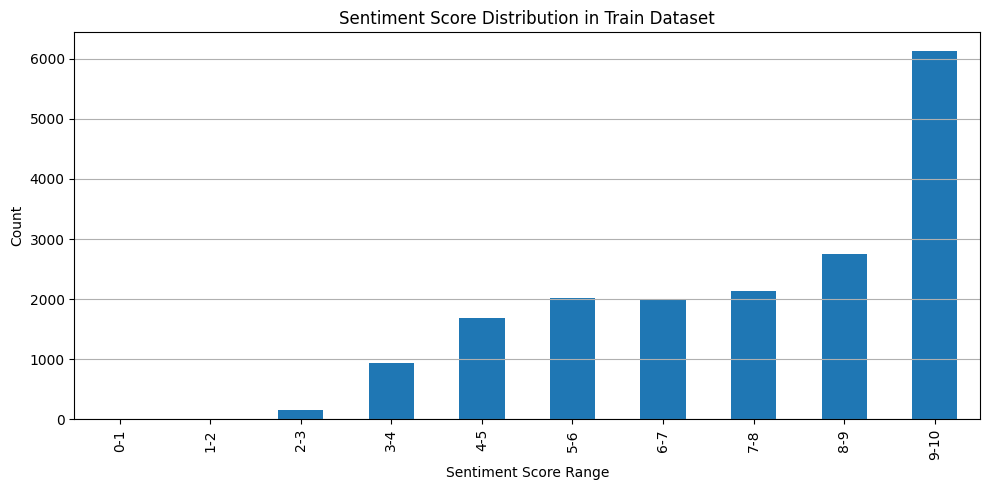

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the bins and labels
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
labels = ['0-1', '1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10']

# Cut the sentiment_score column into bins
grouped_df_train['score_range'] = pd.cut(grouped_df_train['sentiment_score'], bins=bins, labels=labels, include_lowest=True)

# Count how many values fall into each range
range_counts = grouped_df_train['score_range'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(10, 5))
range_counts.plot(kind='bar')
plt.xlabel("Sentiment Score Range")
plt.ylabel("Count")
plt.title("Sentiment Score Distribution in Train Dataset")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


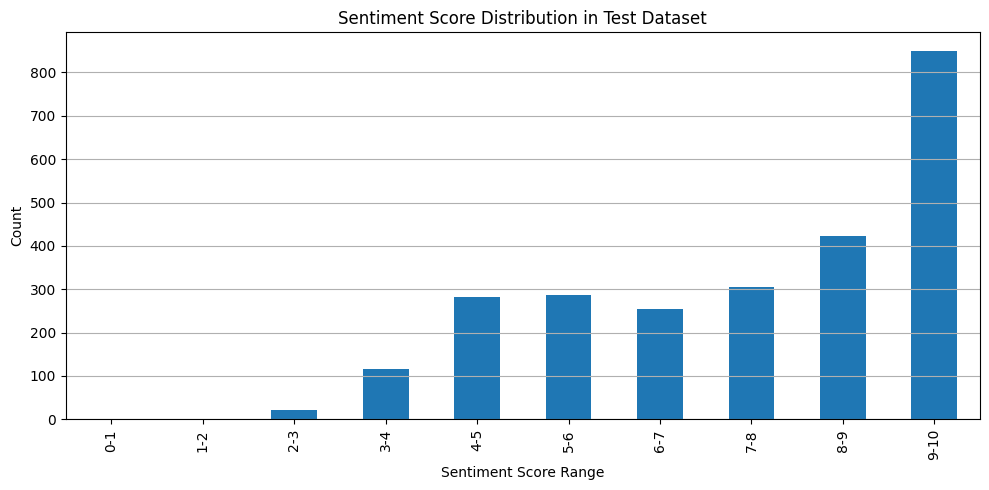

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the bins and labels
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
labels = ['0-1', '1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10']

# Cut the sentiment_score column into bins
grouped_df_test['score_range'] = pd.cut(grouped_df_test['sentiment_score'], bins=bins, labels=labels, include_lowest=True)

# Count how many values fall into each range
range_counts = grouped_df_test['score_range'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(10, 5))
range_counts.plot(kind='bar')
plt.xlabel("Sentiment Score Range")
plt.ylabel("Count")
plt.title("Sentiment Score Distribution in Test Dataset")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [18]:
emotion_base_model = ['afraid', 'angry', 'annoyed', 'anticipating', 'anxious', 'apprehensive', 'ashamed', 'caring', 'confident', 'content', 'devastated', 'disappointed', 'disgusted', 'embarrassed', 'excited', 'faithful', 'furious', 'grateful', 'guilty', 'hopeful', 'impressed', 'jealous', 'joyful', 'lonely', 'nostalgic', 'prepared', 'proud', 'sad', 'sentimental', 'surprised', 'terrified', 'trusting']

In [19]:
print(emotion_base_model)

['afraid', 'angry', 'annoyed', 'anticipating', 'anxious', 'apprehensive', 'ashamed', 'caring', 'confident', 'content', 'devastated', 'disappointed', 'disgusted', 'embarrassed', 'excited', 'faithful', 'furious', 'grateful', 'guilty', 'hopeful', 'impressed', 'jealous', 'joyful', 'lonely', 'nostalgic', 'prepared', 'proud', 'sad', 'sentimental', 'surprised', 'terrified', 'trusting']


In [21]:
from datasets import Dataset
from transformers import AutoTokenizer
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel

def model_training_and_evaluation(emotion_list, grouped_df_train, grouped_df_test, model_type, tokenizer_name='bert-base-uncased', max_len=96):

    df_train_filtered = grouped_df_train[grouped_df_train['context'].isin(emotion_list)].reset_index(drop=True)
    df_test_filtered = grouped_df_test[grouped_df_test['context'].isin(emotion_list)].reset_index(drop=True)

    print(f"\nFiltered Training Samples: {len(df_train_filtered)}")
    print(f"Filtered Testing Samples: {len(df_test_filtered)}")

    # Step 2: Convert pandas DataFrames to HuggingFace Datasets
    hf_dataset_train = Dataset.from_pandas(df_train_filtered)
    hf_dataset_test = Dataset.from_pandas(df_test_filtered)

    # Step 3: Create label mapping based on filtered train dataset
    label_mapping = {label: idx for idx, label in enumerate(sorted(set(hf_dataset_train["context"])))}

    print(f"Label Mapping for this pair: {label_mapping}")

    # Step 4: Define label encoder function
    def encode_labels(example):
        example["labels"] = label_mapping[example["context"]]
        return example

    # Step 5: Apply label encoding
    hf_dataset_train = hf_dataset_train.map(encode_labels)
    hf_dataset_test = hf_dataset_test.map(encode_labels)

    from transformers import AutoTokenizer
    import torch
    # Step 6: Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

    # Step 7: Tokenize utterances
    def tokenize_function(batch):
        return tokenizer(
            batch["utterances"],
            padding='max_length',
            truncation=True,
            max_length=max_len
        )

    tokenized_dataset_train = hf_dataset_train.map(tokenize_function, batched=True)
    tokenized_dataset_test = hf_dataset_test.map(tokenize_function, batched=True)


    tokenized_dataset_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels", "sentiment_score"])
    print(tokenized_dataset_train[0:4])

    tokenized_dataset_test.set_format(type="torch", columns=["input_ids", "attention_mask", "labels", "sentiment_score"])
    print(tokenized_dataset_test[0:4])

    from transformers import AutoTokenizer #DataCollatorWithPadding

    #data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    import torch
    #from transformers import DataCollatorWithPadding
    from torch.utils.data import DataLoader

    train_dataloader = DataLoader(
        tokenized_dataset_train,
        batch_size=16,
        shuffle=True,
        #collate_fn=data_collator  # Dynamic padding applied here
    )

    test_dataloader = DataLoader(
        tokenized_dataset_test,
        batch_size=16,
        shuffle= False,
        #collate_fn=data_collator  # Dynamic padding applied here
    )

    num_labels = len(label_mapping)

    class CustomBERTModel(nn.Module):
        def __init__(self, model_name, num_labels):
            super(CustomBERTModel, self).__init__()
            self.bert = AutoModel.from_pretrained(model_name)

            hidden_size = self.bert.config.hidden_size  # usually 768
            additional_feature_size = 1  # sentiment_score is a scalar

            self.dropout = nn.Dropout(0.3)

            self.classifier = nn.Linear(hidden_size + additional_feature_size, num_labels)

        def forward(self, input_ids, attention_mask, sentiment_score):
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

            # Get [CLS] representation (first token)
            pooled_output = outputs.last_hidden_state[:, 0]  # shape: (batch_size, hidden_size)

            # Reshape sentiment_score to (batch_size, 1)
            sentiment_score = sentiment_score.unsqueeze(1)

            # Concatenate
            combined = torch.cat((pooled_output, sentiment_score), dim=1)

            # Dropout + classification
            combined = self.dropout(combined)
            logits = self.classifier(combined)

            return logits

    model_name = "bert-base-uncased"
    model = CustomBERTModel(model_name, num_labels)

    criterion = nn.CrossEntropyLoss(reduction="none")
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    model.train()

    for epoch in range(1):  # Increase if needed
        total_loss = 0

        for batch_idx, batch in enumerate(train_dataloader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            sentiment_scores = batch["sentiment_score"].to(device)

            optimizer.zero_grad()

            # Forward pass with sentiment_score
            logits = model(input_ids=input_ids, attention_mask=attention_mask, sentiment_score=sentiment_scores)

            # Compute individual losses
            losses = criterion(logits, labels)

            # Normalize sentiment_scores if needed
            normalized_weights = sentiment_scores / sentiment_scores.max()

            # Apply weights
            weighted_losses = losses * normalized_weights
            loss = weighted_losses.mean()

            # Backprop and optimize
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if batch_idx % 10 == 0:
                print(f"Epoch [{epoch+1}], Batch [{batch_idx}], Loss: {loss.item():.4f}")

        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch [{epoch+1}] complete. Average Loss: {avg_loss:.4f}")


    import torch
    import os
    from google.colab import drive

    # Mount Google Drive
    drive.mount('/content/drive')

    # Save dir (change emotion pair as needed)
    #emotion_pair = ('ashamed', 'guilty')
    save_dir = f'/content/drive/MyDrive/saved_models/finegrained_{model_type}'
    os.makedirs(save_dir, exist_ok=True)

    # Save model weights using torch
    model_save_path = os.path.join(save_dir, "pytorch_model.bin")
    torch.save(model.state_dict(), model_save_path)

    # Save tokenizer the usual Hugging Face way
    tokenizer.save_pretrained(save_dir)

    print(f"Model weights saved to {model_save_path}")
    print(f"Tokenizer files saved to {save_dir}")


    # Switch to evaluation mode
    model.eval()

    # Track loss and predictions
    total_loss = 0
    all_predictions = []
    all_labels = []

    criterion = torch.nn.CrossEntropyLoss()  # Or use the same loss as during training if needed

    # No gradient calculation (faster inference)
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]
            sentiment_scores = batch["sentiment_score"]
            labels = batch["labels"]

            # Forward pass through your custom model
            logits = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                sentiment_score=sentiment_scores  # make sure this matches your forward signature
            )

            # Compute loss
            loss = criterion(logits, labels)

            # Store total loss
            total_loss += loss.item()

            # Get predicted labels (highest probability class)
            predictions = torch.argmax(logits, dim=-1)

            # Store labels and predictions
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to tensors (optional since already numpy arrays)
    all_predictions = torch.tensor(all_predictions)
    all_labels = torch.tensor(all_labels)

    # Calculate average validation loss
    avg_loss = total_loss / len(test_dataloader)

    # Compute evaluation metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average="weighted")  # Weighted for class imbalance
    recall = recall_score(all_labels, all_predictions, average="weighted")
    f1 = f1_score(all_labels, all_predictions, average="weighted")
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # Display results
    print(f"Validation Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)


    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping, yticklabels=label_mapping)

    # Labels and title
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix Heatmap")
    plt.show()




Filtered Training Samples: 17793
Filtered Testing Samples: 2540
Label Mapping for this pair: {'afraid': 0, 'angry': 1, 'annoyed': 2, 'anticipating': 3, 'anxious': 4, 'apprehensive': 5, 'ashamed': 6, 'caring': 7, 'confident': 8, 'content': 9, 'devastated': 10, 'disappointed': 11, 'disgusted': 12, 'embarrassed': 13, 'excited': 14, 'faithful': 15, 'furious': 16, 'grateful': 17, 'guilty': 18, 'hopeful': 19, 'impressed': 20, 'jealous': 21, 'joyful': 22, 'lonely': 23, 'nostalgic': 24, 'prepared': 25, 'proud': 26, 'sad': 27, 'sentimental': 28, 'surprised': 29, 'terrified': 30, 'trusting': 31}


Map:   0%|          | 0/17793 [00:00<?, ? examples/s]

Map:   0%|          | 0/2540 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/17793 [00:00<?, ? examples/s]

Map:   0%|          | 0/2540 [00:00<?, ? examples/s]

{'sentiment_score': tensor([4.1100, 9.6100, 9.8200, 8.2900]), 'labels': tensor([28, 29, 20, 23]), 'input_ids': tensor([[  101,  1045,  3342,  2183,  2000,  2156,  1996, 16080,  2007,  2026,
          2190,  2767,  1012,  2009,  2001,  1996,  2034,  2051,  2057,  2412,
          2985,  2051,  2894,  2362,  1012,  2348,  2045,  2001,  1037,  2843,
          1997,  2111,  1010,  2057,  2371,  2066,  1996,  2069,  2111,  1999,
          1996,  2088,  1012,  2001,  2023,  1037,  2767,  2017,  2020,  1999,
          2293,  2007,  1010,  2030,  2074,  1037,  2190,  2767,  1029,  2023,
          2001,  1037,  2190,  2767,  1012,  1045,  3335,  2014,  1012,  2073,
          2038,  2016,  2908,  1029,  2057,  2053,  2936,  2831,  1012,  2821,
          2001,  2023,  2242,  2008,  3047,  2138,  1997,  2019,  6685,  1029,
           102,     0,     0,     0,     0,     0],
        [  101,  2026,  6513,  2288,  2033,  1037,  9004, 21344,  2651,   999,
          2079,  2017,  2066, 21344,  2015,  10

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch [1], Batch [0], Loss: 2.7895
Epoch [1], Batch [10], Loss: 2.7042
Epoch [1], Batch [20], Loss: 2.5225
Epoch [1], Batch [30], Loss: 2.9053
Epoch [1], Batch [40], Loss: 2.3572
Epoch [1], Batch [50], Loss: 2.3325
Epoch [1], Batch [60], Loss: 2.3313
Epoch [1], Batch [70], Loss: 2.0713
Epoch [1], Batch [80], Loss: 2.0044
Epoch [1], Batch [90], Loss: 2.3097
Epoch [1], Batch [100], Loss: 2.0804
Epoch [1], Batch [110], Loss: 1.5128
Epoch [1], Batch [120], Loss: 1.7706
Epoch [1], Batch [130], Loss: 1.9790
Epoch [1], Batch [140], Loss: 2.2306
Epoch [1], Batch [150], Loss: 1.8015
Epoch [1], Batch [160], Loss: 1.5264
Epoch [1], Batch [170], Loss: 1.4325
Epoch [1], Batch [180], Loss: 1.5122
Epoch [1], Batch [190], Loss: 2.2105
Epoch [1], Batch [200], Loss: 1.4519
Epoch [1], Batch [210], Loss: 2.2230
Epoch [1], Batch [220], Loss: 1.8185
Epoch [1], Batch [230], Loss: 1.6574
Epoch [1], Batch [240], Loss: 1.5301
Epoch [1], Batch [250], Loss: 1.2977
Epoch [1], Batch [260], Loss: 1.0438
Epoch [1], B

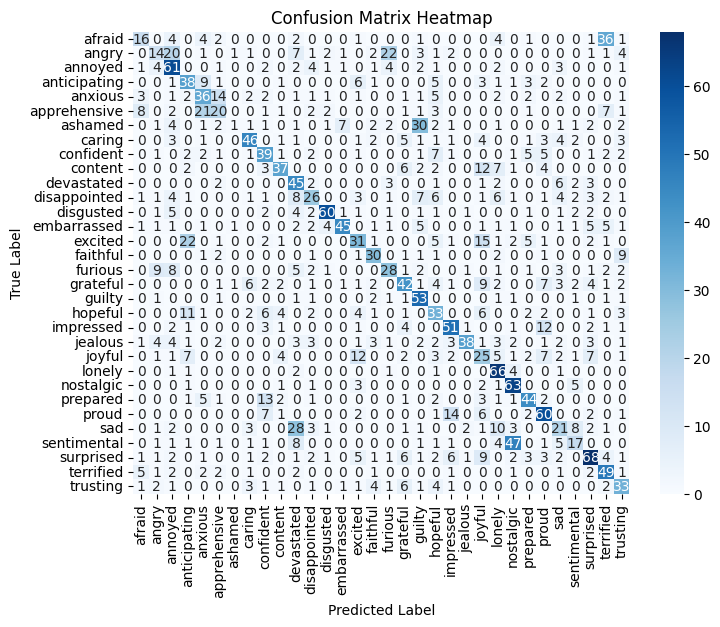

In [22]:
model_training_and_evaluation(
    emotion_list= emotion_base_model,
    grouped_df_train=grouped_df_train,
    grouped_df_test=grouped_df_test,
    model_type = "base_model",
    tokenizer_name='bert-base-uncased',
    max_len=96
)

In [24]:
emotion_misclassified = [
    'devastated', 'sad', 'excited','anticipating','sentimental', 'nostalgic',
    'ashamed', 'guilty',
    'furious', 'angry',
    'terrified', 'afraid'
]

In [29]:
from datasets import Dataset
from transformers import AutoTokenizer
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel

def model_training_and_evaluation(emotion_list, grouped_df_train, grouped_df_test, model_type, tokenizer_name='bert-base-uncased', max_len=96):

    df_train_filtered = grouped_df_train[grouped_df_train['context'].isin(emotion_list)].reset_index(drop=True)
    df_test_filtered = grouped_df_test[grouped_df_test['context'].isin(emotion_list)].reset_index(drop=True)

    print(f"\nFiltered Training Samples: {len(df_train_filtered)}")
    print(f"Filtered Testing Samples: {len(df_test_filtered)}")

    # Step 2: Convert pandas DataFrames to HuggingFace Datasets
    hf_dataset_train = Dataset.from_pandas(df_train_filtered)
    hf_dataset_test = Dataset.from_pandas(df_test_filtered)

    # Step 3: Create label mapping based on filtered train dataset
    label_mapping = {label: idx for idx, label in enumerate(sorted(set(hf_dataset_train["context"])))}

    print(f"Label Mapping for this pair: {label_mapping}")

    # Step 4: Define label encoder function
    def encode_labels(example):
        example["labels"] = label_mapping[example["context"]]
        return example

    # Step 5: Apply label encoding
    hf_dataset_train = hf_dataset_train.map(encode_labels)
    hf_dataset_test = hf_dataset_test.map(encode_labels)

    from transformers import AutoTokenizer
    import torch
    # Step 6: Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

    # Step 7: Tokenize utterances
    def tokenize_function(batch):
        return tokenizer(
            batch["utterances"],
            padding='max_length',
            truncation=True,
            max_length=max_len
        )

    tokenized_dataset_train = hf_dataset_train.map(tokenize_function, batched=True)
    tokenized_dataset_test = hf_dataset_test.map(tokenize_function, batched=True)


    tokenized_dataset_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels", "sentiment_score"])
    print(tokenized_dataset_train[0:4])

    tokenized_dataset_test.set_format(type="torch", columns=["input_ids", "attention_mask", "labels", "sentiment_score"])
    print(tokenized_dataset_test[0:4])

    from transformers import AutoTokenizer #DataCollatorWithPadding

    #data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    import torch
    #from transformers import DataCollatorWithPadding
    from torch.utils.data import DataLoader

    train_dataloader = DataLoader(
        tokenized_dataset_train,
        batch_size=16,
        shuffle=True,
        #collate_fn=data_collator  # Dynamic padding applied here
    )

    test_dataloader = DataLoader(
        tokenized_dataset_test,
        batch_size=16,
        shuffle= False,
        #collate_fn=data_collator  # Dynamic padding applied here
    )

    num_labels = len(label_mapping)

    class CustomBERTModel(nn.Module):
        def __init__(self, model_name, num_labels):
            super(CustomBERTModel, self).__init__()
            self.bert = AutoModel.from_pretrained(model_name)

            hidden_size = self.bert.config.hidden_size  # usually 768
            additional_feature_size = 1  # sentiment_score is a scalar

            self.dropout = nn.Dropout(0.1)

            self.classifier = nn.Linear(hidden_size + additional_feature_size, num_labels)

        def forward(self, input_ids, attention_mask, sentiment_score):
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

            # Get [CLS] representation (first token)
            pooled_output = outputs.last_hidden_state[:, 0]  # shape: (batch_size, hidden_size)

            # Reshape sentiment_score to (batch_size, 1)
            sentiment_score = sentiment_score.unsqueeze(1)

            # Concatenate
            combined = torch.cat((pooled_output, sentiment_score), dim=1)

            # Dropout + classification
            combined = self.dropout(combined)
            logits = self.classifier(combined)

            return logits

    model_name = "bert-base-uncased"
    model = CustomBERTModel(model_name, num_labels)

    criterion = nn.CrossEntropyLoss(reduction="none")
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    model.train()

    for epoch in range(3):
        total_loss = 0

        for batch_idx, batch in enumerate(train_dataloader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            sentiment_scores = batch["sentiment_score"].to(device)

            optimizer.zero_grad()

            # Forward pass with sentiment_score
            logits = model(input_ids=input_ids, attention_mask=attention_mask, sentiment_score=sentiment_scores)

            # Compute individual losses
            losses = criterion(logits, labels)

            # Normalize sentiment_scores if needed
            normalized_weights = sentiment_scores / sentiment_scores.max()

            # Apply weights
            weighted_losses = losses * normalized_weights
            loss = weighted_losses.mean()

            # Backprop and optimize
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if batch_idx % 10 == 0:
                print(f"Epoch [{epoch+1}], Batch [{batch_idx}], Loss: {loss.item():.4f}")

        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch [{epoch+1}] complete. Average Loss: {avg_loss:.4f}")


    import torch
    import os
    from google.colab import drive

    # Mount Google Drive
    drive.mount('/content/drive')

    # Save dir (change emotion pair as needed)
    #emotion_pair = ('ashamed', 'guilty')
    save_dir = f'/content/drive/MyDrive/saved_models/finegrained_{model_type}'
    os.makedirs(save_dir, exist_ok=True)

    # Save model weights using torch
    model_save_path = os.path.join(save_dir, "pytorch_model.bin")
    torch.save(model.state_dict(), model_save_path)

    # Save tokenizer the usual Hugging Face way
    tokenizer.save_pretrained(save_dir)

    print(f"Model weights saved to {model_save_path}")
    print(f"Tokenizer files saved to {save_dir}")


    # Switch to evaluation mode
    model.eval()

    # Track loss and predictions
    total_loss = 0
    all_predictions = []
    all_labels = []

    criterion = torch.nn.CrossEntropyLoss()  # Or use the same loss as during training if needed

    # No gradient calculation (faster inference)
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]
            sentiment_scores = batch["sentiment_score"]
            labels = batch["labels"]

            # Forward pass through your custom model
            logits = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                sentiment_score=sentiment_scores  # make sure this matches your forward signature
            )

            # Compute loss
            loss = criterion(logits, labels)

            # Store total loss
            total_loss += loss.item()

            # Get predicted labels (highest probability class)
            predictions = torch.argmax(logits, dim=-1)

            # Store labels and predictions
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to tensors (optional since already numpy arrays)
    all_predictions = torch.tensor(all_predictions)
    all_labels = torch.tensor(all_labels)

    # Calculate average validation loss
    avg_loss = total_loss / len(test_dataloader)

    # Compute evaluation metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average="weighted")  # Weighted for class imbalance
    recall = recall_score(all_labels, all_predictions, average="weighted")
    f1 = f1_score(all_labels, all_predictions, average="weighted")
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # Display results
    print(f"Validation Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)


    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping, yticklabels=label_mapping)

    # Labels and title
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix Heatmap")
    plt.show()




Filtered Training Samples: 6749
Filtered Testing Samples: 911
Label Mapping for this pair: {'afraid': 0, 'angry': 1, 'anticipating': 2, 'ashamed': 3, 'devastated': 4, 'excited': 5, 'furious': 6, 'guilty': 7, 'nostalgic': 8, 'sad': 9, 'sentimental': 10, 'terrified': 11}


Map:   0%|          | 0/6749 [00:00<?, ? examples/s]

Map:   0%|          | 0/911 [00:00<?, ? examples/s]

Map:   0%|          | 0/6749 [00:00<?, ? examples/s]

Map:   0%|          | 0/911 [00:00<?, ? examples/s]

{'sentiment_score': tensor([4.1100, 5.4300, 3.3300, 9.4900]), 'labels': tensor([10,  3,  7,  8]), 'input_ids': tensor([[  101,  1045,  3342,  2183,  2000,  2156,  1996, 16080,  2007,  2026,
          2190,  2767,  1012,  2009,  2001,  1996,  2034,  2051,  2057,  2412,
          2985,  2051,  2894,  2362,  1012,  2348,  2045,  2001,  1037,  2843,
          1997,  2111,  1010,  2057,  2371,  2066,  1996,  2069,  2111,  1999,
          1996,  2088,  1012,  2001,  2023,  1037,  2767,  2017,  2020,  1999,
          2293,  2007,  1010,  2030,  2074,  1037,  2190,  2767,  1029,  2023,
          2001,  1037,  2190,  2767,  1012,  1045,  3335,  2014,  1012,  2073,
          2038,  2016,  2908,  1029,  2057,  2053,  2936,  2831,  1012,  2821,
          2001,  2023,  2242,  2008,  3047,  2138,  1997,  2019,  6685,  1029,
           102,     0,     0,     0,     0,     0],
        [  101,  1045,  2001,  3788,  2006,  1996,  2346,  1012,  1045,  2387,
          1037, 11693,  6843,  1998,  1045,  21

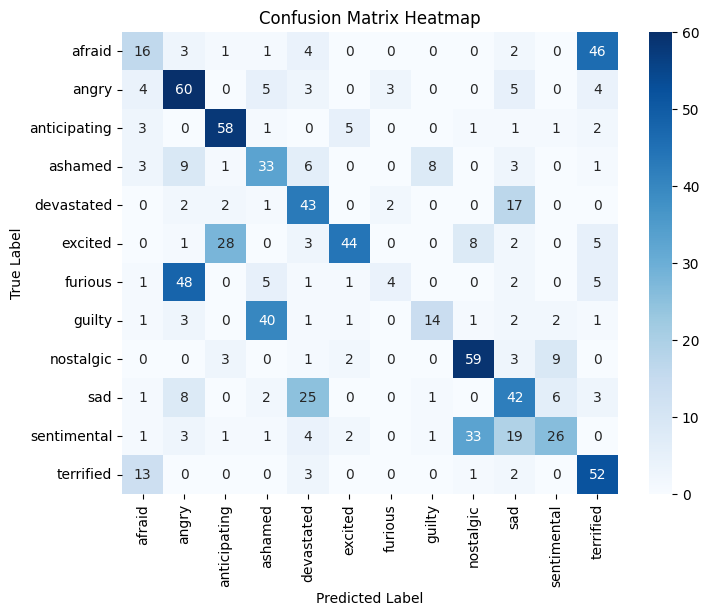

In [ ]:
model_training_and_evaluation(
    emotion_list= emotion_misclassified,
    grouped_df_train=grouped_df_train,
    grouped_df_test=grouped_df_test,
    model_type = "stack_model",
    tokenizer_name='bert-base-uncased',  # or your custom model tokenizer
    max_len=96
)


In [33]:
!pip install captum


Device set to use cpu


Your input conversation is:  Oh nice. I won a lotterty ticket today, What a lucky man you are, I think you also can win one day, We will see dear.


### 🎯 **Predicted Emotion:** <span style='font-size:24px; color:darkred;'>**JOYFUL**</span>

<ipython-input-35-242a122c766b>:141: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


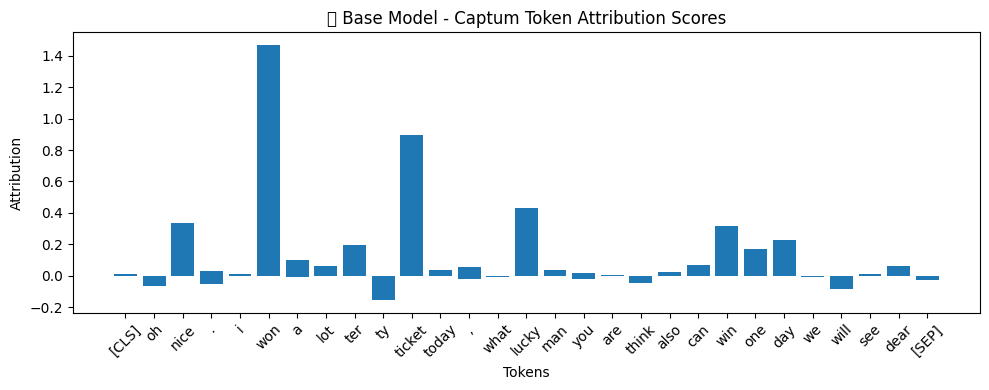

In [35]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer, pipeline
from captum.attr import IntegratedGradients
from IPython.display import display, HTML

# -------- Load Base Model --------
class CustomBERTModel(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size + 1, num_labels)

    def forward(self, input_ids, attention_mask, sentiment_score):
        pooled = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0]
        sentiment_score = sentiment_score.unsqueeze(1)
        combined = torch.cat((pooled, sentiment_score), dim=1)
        combined = self.dropout(combined)
        return self.classifier(combined)

# Base model paths
model_path = "/content/drive/MyDrive/saved_models/finegrained_base_model"
num_labels = 32

# Load base model
model = CustomBERTModel("bert-base-uncased", num_labels)
model.load_state_dict(torch.load(f"{model_path}/pytorch_model.bin", map_location="cpu"))
model.eval()

tokenizer = AutoTokenizer.from_pretrained(model_path)

# Emotion classifier for sentiment score
emotion_classifier = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    truncation=True,
    max_length=512,
    top_k=None
)

def get_emotion_score(text):
    result = emotion_classifier(text)
    if isinstance(result, list) and isinstance(result[0], list):
        result = result[0]
    max_prob = max([r['score'] for r in result])
    return round(max_prob * 10, 2)

# Wrapper for embeddings
class ForwardFuncWithEmbeddings(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, embeddings, attention_mask, sentiment_score):
        pooled = self.model.bert(inputs_embeds=embeddings, attention_mask=attention_mask).last_hidden_state[:, 0]
        if sentiment_score.dim() == 1:
            sentiment_score = sentiment_score.unsqueeze(1)
        sentiment_score = sentiment_score.expand(embeddings.size(0), 1)
        combined = torch.cat((pooled, sentiment_score), dim=1)
        combined = self.model.dropout(combined)
        return self.model.classifier(combined)

# -------- Example Input --------
text = "Oh nice. I won a lotterty ticket today, What a lucky man you are, I think you also can win one day, We will see dear."
print("Your input conversation is: ",text)
# Get sentiment score
score = get_emotion_score(text)
sentiment_score = torch.tensor([score], dtype=torch.float)

# Tokenize
inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=96)
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

# Predict label
with torch.no_grad():
    logits = model(input_ids, attention_mask, sentiment_score)
predicted_label = torch.argmax(logits, dim=1).item()

# Define your emotion label mapping (based on your training labels)
label_mapping = {
    0: 'afraid', 1: 'angry', 2: 'annoyed', 3: 'anticipating', 4: 'anxious', 5: 'apprehensive',
    6: 'ashamed', 7: 'caring', 8: 'confident', 9: 'content', 10: 'devastated', 11: 'disappointed',
    12: 'disgusted', 13: 'embarrassed', 14: 'excited', 15: 'faithful', 16: 'furious', 17: 'grateful',
    18: 'guilty', 19: 'hopeful', 20: 'impressed', 21: 'jealous', 22: 'joyful', 23: 'lonely',
    24: 'nostalgic', 25: 'prepared', 26: 'proud', 27: 'sad', 28: 'sentimental', 29: 'surprised',
    30: 'terrified', 31: 'trusting'
}

# Predict label
with torch.no_grad():
    logits = model(input_ids, attention_mask, sentiment_score)
predicted_label = torch.argmax(logits, dim=1).item()

# ✅ Print predicted emotion
predicted_emotion = label_mapping.get(predicted_label, "Unknown")
#print(f"🎯 Predicted Emotion: {predicted_emotion}")

from IPython.display import display, Markdown
def print_highlighted_emotion(predicted_emotion):
    display(Markdown(f"<span style='font-size:22px; font-weight: bold; color: darkred;'>🎯 **Predicted Emotion:** `{predicted_emotion.upper()}`</span>"))

# Assuming predicted_emotion is the string like "sad" or "angry"
display(Markdown(f"### 🎯 **Predicted Emotion:** <span style='font-size:24px; color:darkred;'>**{predicted_emotion.upper()}**</span>"))


# Captum
embeddings = model.bert.embeddings(input_ids)
wrapper = ForwardFuncWithEmbeddings(model)
ig = IntegratedGradients(wrapper)

attributions, _ = ig.attribute(
    embeddings,
    additional_forward_args=(attention_mask, sentiment_score),
    target=predicted_label,
    n_steps=20,
    return_convergence_delta=True
)

# Visualize
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
scores = attributions.sum(dim=2).squeeze(0)

# Filter out [PAD]
filtered_tokens = []
filtered_scores = []
for tok, s in zip(tokens, scores):
    if tok != "[PAD]":
        filtered_tokens.append(tok.replace("##", ""))
        filtered_scores.append(s.item())

# Bar chart
plt.figure(figsize=(10, 4))
plt.bar(filtered_tokens, filtered_scores)
plt.title("📊 Base Model - Captum Token Attribution Scores")
plt.xlabel("Tokens")
plt.ylabel("Attribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Inline color-highlighted tokens
highlighted = ""
for token, score in zip(filtered_tokens, filtered_scores):
    norm_score = (score + 1) / 2  # Normalize [-1,1] -> [0,1]
    color = f"rgba(255, 165, 0, {norm_score})"
    highlighted += f"<span style='background-color:{color}; padding:2px; margin:1px'>{token} </span>"

display(HTML(f"<div style='font-family:monospace'>{highlighted}</div>"))


Device set to use cpu


Your input conversation is:  This situation is really dangerous, Why do you think so?, USA rises tariffs on Sri Lanka. So very diffuity sell our products for USA., Oh my goat. our business in trouble.


### 🎯 **Predicted Emotion:** <span style='font-size:24px; color:darkred;'>**ANNOYED**</span>

<ipython-input-38-76a7d268cae6>:141: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


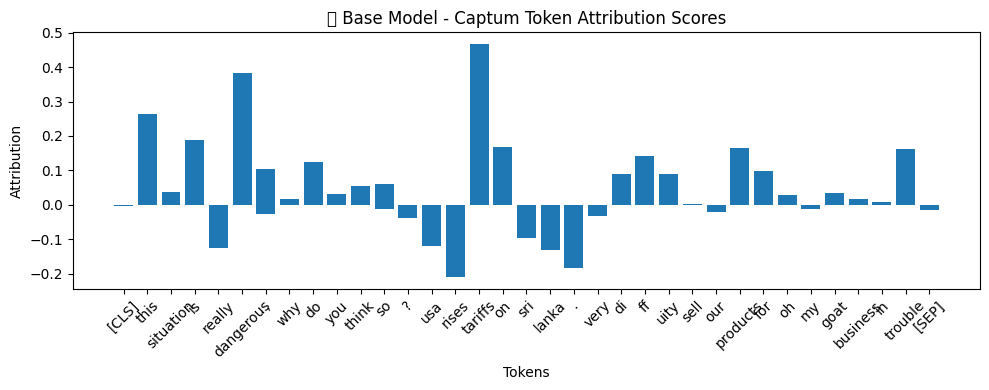

In [38]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer, pipeline
from captum.attr import IntegratedGradients
from IPython.display import display, HTML

# -------- Load Base Model --------
class CustomBERTModel(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size + 1, num_labels)

    def forward(self, input_ids, attention_mask, sentiment_score):
        pooled = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0]
        sentiment_score = sentiment_score.unsqueeze(1)
        combined = torch.cat((pooled, sentiment_score), dim=1)
        combined = self.dropout(combined)
        return self.classifier(combined)

# Base model paths
model_path = "/content/drive/MyDrive/saved_models/finegrained_base_model"
num_labels = 32

# Load base model
model = CustomBERTModel("bert-base-uncased", num_labels)
model.load_state_dict(torch.load(f"{model_path}/pytorch_model.bin", map_location="cpu"))
model.eval()

tokenizer = AutoTokenizer.from_pretrained(model_path)

# Emotion classifier for sentiment score
emotion_classifier = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    truncation=True,
    max_length=512,
    top_k=None
)

def get_emotion_score(text):
    result = emotion_classifier(text)
    if isinstance(result, list) and isinstance(result[0], list):
        result = result[0]
    max_prob = max([r['score'] for r in result])
    return round(max_prob * 10, 2)

# Wrapper for embeddings
class ForwardFuncWithEmbeddings(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, embeddings, attention_mask, sentiment_score):
        pooled = self.model.bert(inputs_embeds=embeddings, attention_mask=attention_mask).last_hidden_state[:, 0]
        if sentiment_score.dim() == 1:
            sentiment_score = sentiment_score.unsqueeze(1)
        sentiment_score = sentiment_score.expand(embeddings.size(0), 1)
        combined = torch.cat((pooled, sentiment_score), dim=1)
        combined = self.model.dropout(combined)
        return self.model.classifier(combined)

# -------- Example Input --------
text = "This situation is really dangerous, Why do you think so?, USA rises tariffs on Sri Lanka. So very diffuity sell our products for USA., Oh my goat. our business in trouble."
print("Your input conversation is: ",text)
# Get sentiment score
score = get_emotion_score(text)
sentiment_score = torch.tensor([score], dtype=torch.float)

# Tokenize
inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=96)
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

# Predict label
with torch.no_grad():
    logits = model(input_ids, attention_mask, sentiment_score)
predicted_label = torch.argmax(logits, dim=1).item()

# Define your emotion label mapping (based on your training labels)
label_mapping = {
    0: 'afraid', 1: 'angry', 2: 'annoyed', 3: 'anticipating', 4: 'anxious', 5: 'apprehensive',
    6: 'ashamed', 7: 'caring', 8: 'confident', 9: 'content', 10: 'devastated', 11: 'disappointed',
    12: 'disgusted', 13: 'embarrassed', 14: 'excited', 15: 'faithful', 16: 'furious', 17: 'grateful',
    18: 'guilty', 19: 'hopeful', 20: 'impressed', 21: 'jealous', 22: 'joyful', 23: 'lonely',
    24: 'nostalgic', 25: 'prepared', 26: 'proud', 27: 'sad', 28: 'sentimental', 29: 'surprised',
    30: 'terrified', 31: 'trusting'
}

# Predict label
with torch.no_grad():
    logits = model(input_ids, attention_mask, sentiment_score)
predicted_label = torch.argmax(logits, dim=1).item()

# ✅ Print predicted emotion
predicted_emotion = label_mapping.get(predicted_label, "Unknown")
#print(f"🎯 Predicted Emotion: {predicted_emotion}")

from IPython.display import display, Markdown
def print_highlighted_emotion(predicted_emotion):
    display(Markdown(f"<span style='font-size:22px; font-weight: bold; color: darkred;'>🎯 **Predicted Emotion:** `{predicted_emotion.upper()}`</span>"))

# Assuming predicted_emotion is the string like "sad" or "angry"
display(Markdown(f"### 🎯 **Predicted Emotion:** <span style='font-size:24px; color:darkred;'>**{predicted_emotion.upper()}**</span>"))


# Captum
embeddings = model.bert.embeddings(input_ids)
wrapper = ForwardFuncWithEmbeddings(model)
ig = IntegratedGradients(wrapper)

attributions, _ = ig.attribute(
    embeddings,
    additional_forward_args=(attention_mask, sentiment_score),
    target=predicted_label,
    n_steps=20,
    return_convergence_delta=True
)

# Visualize
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
scores = attributions.sum(dim=2).squeeze(0)

# Filter out [PAD]
filtered_tokens = []
filtered_scores = []
for tok, s in zip(tokens, scores):
    if tok != "[PAD]":
        filtered_tokens.append(tok.replace("##", ""))
        filtered_scores.append(s.item())

# Bar chart
plt.figure(figsize=(10, 4))
plt.bar(filtered_tokens, filtered_scores)
plt.title("📊 Base Model - Captum Token Attribution Scores")
plt.xlabel("Tokens")
plt.ylabel("Attribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Inline color-highlighted tokens
highlighted = ""
for token, score in zip(filtered_tokens, filtered_scores):
    norm_score = (score + 1) / 2  # Normalize [-1,1] -> [0,1]
    color = f"rgba(255, 165, 0, {norm_score})"
    highlighted += f"<span style='background-color:{color}; padding:2px; margin:1px'>{token} </span>"

display(HTML(f"<div style='font-family:monospace'>{highlighted}</div>"))


Device set to use cpu


Your input conversation is:  Do you know? Mr. Peter buys a very large TV today, What? why he need a large one, I don't know. I think it is too big for him, I mean that old man no need a use of TV.


### 🎯 **Predicted Emotion:** <span style='font-size:24px; color:darkred;'>**JEALOUS**</span>

<ipython-input-39-db363b9ef613>:141: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


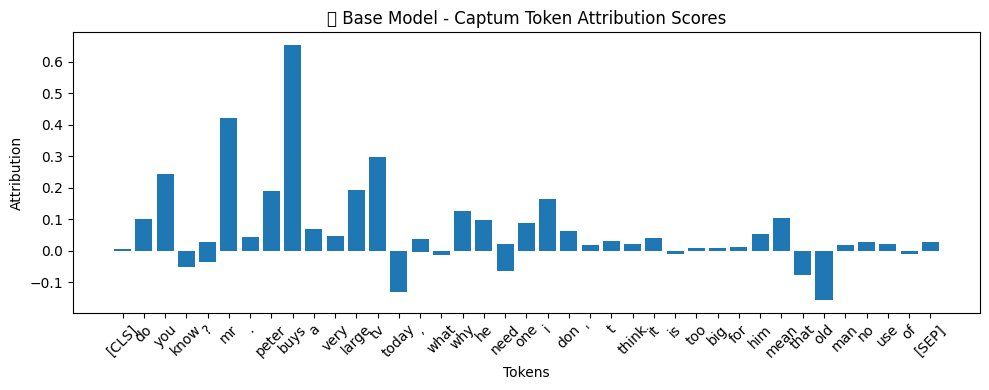

In [39]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer, pipeline
from captum.attr import IntegratedGradients
from IPython.display import display, HTML

# -------- Load Base Model --------
class CustomBERTModel(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size + 1, num_labels)

    def forward(self, input_ids, attention_mask, sentiment_score):
        pooled = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0]
        sentiment_score = sentiment_score.unsqueeze(1)
        combined = torch.cat((pooled, sentiment_score), dim=1)
        combined = self.dropout(combined)
        return self.classifier(combined)

# Base model paths
model_path = "/content/drive/MyDrive/saved_models/finegrained_base_model"
num_labels = 32

# Load base model
model = CustomBERTModel("bert-base-uncased", num_labels)
model.load_state_dict(torch.load(f"{model_path}/pytorch_model.bin", map_location="cpu"))
model.eval()

tokenizer = AutoTokenizer.from_pretrained(model_path)

# Emotion classifier for sentiment score
emotion_classifier = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    truncation=True,
    max_length=512,
    top_k=None
)

def get_emotion_score(text):
    result = emotion_classifier(text)
    if isinstance(result, list) and isinstance(result[0], list):
        result = result[0]
    max_prob = max([r['score'] for r in result])
    return round(max_prob * 10, 2)

# Wrapper for embeddings
class ForwardFuncWithEmbeddings(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, embeddings, attention_mask, sentiment_score):
        pooled = self.model.bert(inputs_embeds=embeddings, attention_mask=attention_mask).last_hidden_state[:, 0]
        if sentiment_score.dim() == 1:
            sentiment_score = sentiment_score.unsqueeze(1)
        sentiment_score = sentiment_score.expand(embeddings.size(0), 1)
        combined = torch.cat((pooled, sentiment_score), dim=1)
        combined = self.model.dropout(combined)
        return self.model.classifier(combined)

# -------- Example Input --------
text = "Do you know? Mr. Peter buys a very large TV today, What? why he need a large one, I don't know. I think it is too big for him, I mean that old man no need a use of TV."
print("Your input conversation is: ",text)
# Get sentiment score
score = get_emotion_score(text)
sentiment_score = torch.tensor([score], dtype=torch.float)

# Tokenize
inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=96)
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

# Predict label
with torch.no_grad():
    logits = model(input_ids, attention_mask, sentiment_score)
predicted_label = torch.argmax(logits, dim=1).item()

# Define your emotion label mapping (based on your training labels)
label_mapping = {
    0: 'afraid', 1: 'angry', 2: 'annoyed', 3: 'anticipating', 4: 'anxious', 5: 'apprehensive',
    6: 'ashamed', 7: 'caring', 8: 'confident', 9: 'content', 10: 'devastated', 11: 'disappointed',
    12: 'disgusted', 13: 'embarrassed', 14: 'excited', 15: 'faithful', 16: 'furious', 17: 'grateful',
    18: 'guilty', 19: 'hopeful', 20: 'impressed', 21: 'jealous', 22: 'joyful', 23: 'lonely',
    24: 'nostalgic', 25: 'prepared', 26: 'proud', 27: 'sad', 28: 'sentimental', 29: 'surprised',
    30: 'terrified', 31: 'trusting'
}

# Predict label
with torch.no_grad():
    logits = model(input_ids, attention_mask, sentiment_score)
predicted_label = torch.argmax(logits, dim=1).item()

# ✅ Print predicted emotion
predicted_emotion = label_mapping.get(predicted_label, "Unknown")
#print(f"🎯 Predicted Emotion: {predicted_emotion}")

from IPython.display import display, Markdown
def print_highlighted_emotion(predicted_emotion):
    display(Markdown(f"<span style='font-size:22px; font-weight: bold; color: darkred;'>🎯 **Predicted Emotion:** `{predicted_emotion.upper()}`</span>"))

# Assuming predicted_emotion is the string like "sad" or "angry"
display(Markdown(f"### 🎯 **Predicted Emotion:** <span style='font-size:24px; color:darkred;'>**{predicted_emotion.upper()}**</span>"))


# Captum
embeddings = model.bert.embeddings(input_ids)
wrapper = ForwardFuncWithEmbeddings(model)
ig = IntegratedGradients(wrapper)

attributions, _ = ig.attribute(
    embeddings,
    additional_forward_args=(attention_mask, sentiment_score),
    target=predicted_label,
    n_steps=20,
    return_convergence_delta=True
)

# Visualize
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
scores = attributions.sum(dim=2).squeeze(0)

# Filter out [PAD]
filtered_tokens = []
filtered_scores = []
for tok, s in zip(tokens, scores):
    if tok != "[PAD]":
        filtered_tokens.append(tok.replace("##", ""))
        filtered_scores.append(s.item())

# Bar chart
plt.figure(figsize=(10, 4))
plt.bar(filtered_tokens, filtered_scores)
plt.title("📊 Base Model - Captum Token Attribution Scores")
plt.xlabel("Tokens")
plt.ylabel("Attribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Inline color-highlighted tokens
highlighted = ""
for token, score in zip(filtered_tokens, filtered_scores):
    norm_score = (score + 1) / 2  # Normalize [-1,1] -> [0,1]
    color = f"rgba(255, 165, 0, {norm_score})"
    highlighted += f"<span style='background-color:{color}; padding:2px; margin:1px'>{token} </span>"

display(HTML(f"<div style='font-family:monospace'>{highlighted}</div>"))


Device set to use cpu


Your input conversation is:  Tommorow we go to nuwara eliya dear, oh what a lovely journey, Yes yes I cant wait till tomorrow, Wait very few hours dear.


### 🎯 **Predicted Emotion:** <span style='font-size:24px; color:darkred;'>**ANTICIPATING**</span>

<ipython-input-40-7a6f6412b748>:141: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


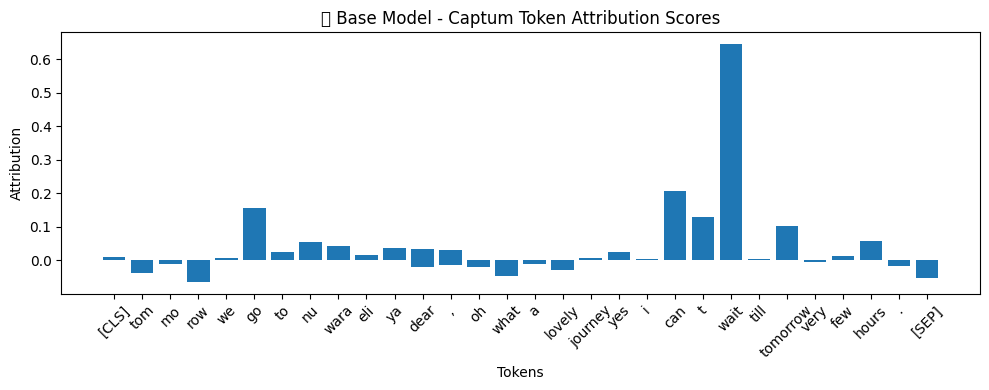

In [40]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer, pipeline
from captum.attr import IntegratedGradients
from IPython.display import display, HTML

# -------- Load Base Model --------
class CustomBERTModel(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size + 1, num_labels)

    def forward(self, input_ids, attention_mask, sentiment_score):
        pooled = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0]
        sentiment_score = sentiment_score.unsqueeze(1)
        combined = torch.cat((pooled, sentiment_score), dim=1)
        combined = self.dropout(combined)
        return self.classifier(combined)

# Base model paths
model_path = "/content/drive/MyDrive/saved_models/finegrained_base_model"
num_labels = 32

# Load base model
model = CustomBERTModel("bert-base-uncased", num_labels)
model.load_state_dict(torch.load(f"{model_path}/pytorch_model.bin", map_location="cpu"))
model.eval()

tokenizer = AutoTokenizer.from_pretrained(model_path)

# Emotion classifier for sentiment score
emotion_classifier = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    truncation=True,
    max_length=512,
    top_k=None
)

def get_emotion_score(text):
    result = emotion_classifier(text)
    if isinstance(result, list) and isinstance(result[0], list):
        result = result[0]
    max_prob = max([r['score'] for r in result])
    return round(max_prob * 10, 2)

# Wrapper for embeddings
class ForwardFuncWithEmbeddings(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, embeddings, attention_mask, sentiment_score):
        pooled = self.model.bert(inputs_embeds=embeddings, attention_mask=attention_mask).last_hidden_state[:, 0]
        if sentiment_score.dim() == 1:
            sentiment_score = sentiment_score.unsqueeze(1)
        sentiment_score = sentiment_score.expand(embeddings.size(0), 1)
        combined = torch.cat((pooled, sentiment_score), dim=1)
        combined = self.model.dropout(combined)
        return self.model.classifier(combined)

# -------- Example Input --------
text = "Tommorow we go to nuwara eliya dear, oh what a lovely journey, Yes yes I cant wait till tomorrow, Wait very few hours dear."
print("Your input conversation is: ",text)
# Get sentiment score
score = get_emotion_score(text)
sentiment_score = torch.tensor([score], dtype=torch.float)

# Tokenize
inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=96)
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

# Predict label
with torch.no_grad():
    logits = model(input_ids, attention_mask, sentiment_score)
predicted_label = torch.argmax(logits, dim=1).item()

# Define your emotion label mapping (based on your training labels)
label_mapping = {
    0: 'afraid', 1: 'angry', 2: 'annoyed', 3: 'anticipating', 4: 'anxious', 5: 'apprehensive',
    6: 'ashamed', 7: 'caring', 8: 'confident', 9: 'content', 10: 'devastated', 11: 'disappointed',
    12: 'disgusted', 13: 'embarrassed', 14: 'excited', 15: 'faithful', 16: 'furious', 17: 'grateful',
    18: 'guilty', 19: 'hopeful', 20: 'impressed', 21: 'jealous', 22: 'joyful', 23: 'lonely',
    24: 'nostalgic', 25: 'prepared', 26: 'proud', 27: 'sad', 28: 'sentimental', 29: 'surprised',
    30: 'terrified', 31: 'trusting'
}

# Predict label
with torch.no_grad():
    logits = model(input_ids, attention_mask, sentiment_score)
predicted_label = torch.argmax(logits, dim=1).item()

# ✅ Print predicted emotion
predicted_emotion = label_mapping.get(predicted_label, "Unknown")
#print(f"🎯 Predicted Emotion: {predicted_emotion}")

from IPython.display import display, Markdown
def print_highlighted_emotion(predicted_emotion):
    display(Markdown(f"<span style='font-size:22px; font-weight: bold; color: darkred;'>🎯 **Predicted Emotion:** `{predicted_emotion.upper()}`</span>"))

# Assuming predicted_emotion is the string like "sad" or "angry"
display(Markdown(f"### 🎯 **Predicted Emotion:** <span style='font-size:24px; color:darkred;'>**{predicted_emotion.upper()}**</span>"))


# Captum
embeddings = model.bert.embeddings(input_ids)
wrapper = ForwardFuncWithEmbeddings(model)
ig = IntegratedGradients(wrapper)

attributions, _ = ig.attribute(
    embeddings,
    additional_forward_args=(attention_mask, sentiment_score),
    target=predicted_label,
    n_steps=20,
    return_convergence_delta=True
)

# Visualize
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
scores = attributions.sum(dim=2).squeeze(0)

# Filter out [PAD]
filtered_tokens = []
filtered_scores = []
for tok, s in zip(tokens, scores):
    if tok != "[PAD]":
        filtered_tokens.append(tok.replace("##", ""))
        filtered_scores.append(s.item())

# Bar chart
plt.figure(figsize=(10, 4))
plt.bar(filtered_tokens, filtered_scores)
plt.title("📊 Base Model - Captum Token Attribution Scores")
plt.xlabel("Tokens")
plt.ylabel("Attribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Inline color-highlighted tokens
highlighted = ""
for token, score in zip(filtered_tokens, filtered_scores):
    norm_score = (score + 1) / 2  # Normalize [-1,1] -> [0,1]
    color = f"rgba(255, 165, 0, {norm_score})"
    highlighted += f"<span style='background-color:{color}; padding:2px; margin:1px'>{token} </span>"

display(HTML(f"<div style='font-family:monospace'>{highlighted}</div>"))


Device set to use cpu


Your input conversation is:  I have nobody to talking with, Why don't you have friends?, I have no frinds now. All of them are far away, oh my goat. I would like to be a friend of you


### 🎯 **Predicted Emotion:** <span style='font-size:24px; color:darkred;'>**LONELY**</span>

<ipython-input-43-ce14c70ebf88>:141: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


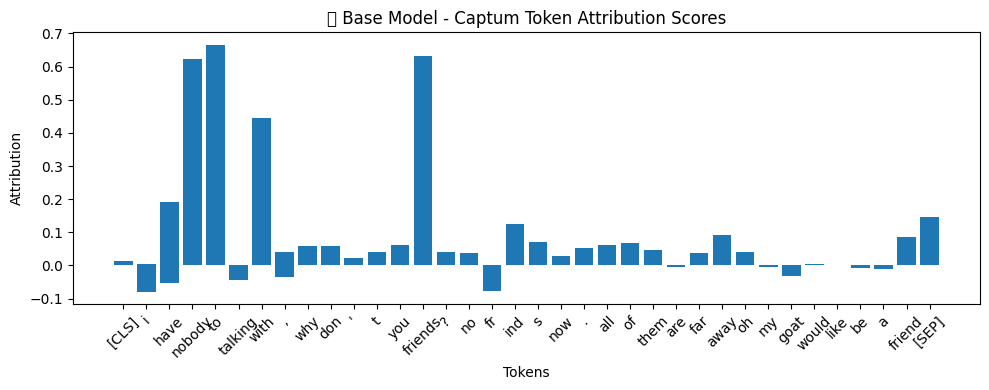

In [43]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer, pipeline
from captum.attr import IntegratedGradients
from IPython.display import display, HTML

# -------- Load Base Model --------
class CustomBERTModel(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size + 1, num_labels)

    def forward(self, input_ids, attention_mask, sentiment_score):
        pooled = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0]
        sentiment_score = sentiment_score.unsqueeze(1)
        combined = torch.cat((pooled, sentiment_score), dim=1)
        combined = self.dropout(combined)
        return self.classifier(combined)

# Base model paths
model_path = "/content/drive/MyDrive/saved_models/finegrained_base_model"
num_labels = 32

# Load base model
model = CustomBERTModel("bert-base-uncased", num_labels)
model.load_state_dict(torch.load(f"{model_path}/pytorch_model.bin", map_location="cpu"))
model.eval()

tokenizer = AutoTokenizer.from_pretrained(model_path)

# Emotion classifier for sentiment score
emotion_classifier = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    truncation=True,
    max_length=512,
    top_k=None
)

def get_emotion_score(text):
    result = emotion_classifier(text)
    if isinstance(result, list) and isinstance(result[0], list):
        result = result[0]
    max_prob = max([r['score'] for r in result])
    return round(max_prob * 10, 2)

# Wrapper for embeddings
class ForwardFuncWithEmbeddings(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, embeddings, attention_mask, sentiment_score):
        pooled = self.model.bert(inputs_embeds=embeddings, attention_mask=attention_mask).last_hidden_state[:, 0]
        if sentiment_score.dim() == 1:
            sentiment_score = sentiment_score.unsqueeze(1)
        sentiment_score = sentiment_score.expand(embeddings.size(0), 1)
        combined = torch.cat((pooled, sentiment_score), dim=1)
        combined = self.model.dropout(combined)
        return self.model.classifier(combined)

# -------- Example Input --------
text = "I have nobody to talking with, Why don't you have friends?, I have no frinds now. All of them are far away, oh my goat. I would like to be a friend of you"
print("Your input conversation is: ",text)
# Get sentiment score
score = get_emotion_score(text)
sentiment_score = torch.tensor([score], dtype=torch.float)

# Tokenize
inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=96)
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

# Predict label
with torch.no_grad():
    logits = model(input_ids, attention_mask, sentiment_score)
predicted_label = torch.argmax(logits, dim=1).item()

# Define your emotion label mapping (based on your training labels)
label_mapping = {
    0: 'afraid', 1: 'angry', 2: 'annoyed', 3: 'anticipating', 4: 'anxious', 5: 'apprehensive',
    6: 'ashamed', 7: 'caring', 8: 'confident', 9: 'content', 10: 'devastated', 11: 'disappointed',
    12: 'disgusted', 13: 'embarrassed', 14: 'excited', 15: 'faithful', 16: 'furious', 17: 'grateful',
    18: 'guilty', 19: 'hopeful', 20: 'impressed', 21: 'jealous', 22: 'joyful', 23: 'lonely',
    24: 'nostalgic', 25: 'prepared', 26: 'proud', 27: 'sad', 28: 'sentimental', 29: 'surprised',
    30: 'terrified', 31: 'trusting'
}

# Predict label
with torch.no_grad():
    logits = model(input_ids, attention_mask, sentiment_score)
predicted_label = torch.argmax(logits, dim=1).item()

# ✅ Print predicted emotion
predicted_emotion = label_mapping.get(predicted_label, "Unknown")
#print(f"🎯 Predicted Emotion: {predicted_emotion}")

from IPython.display import display, Markdown
def print_highlighted_emotion(predicted_emotion):
    display(Markdown(f"<span style='font-size:22px; font-weight: bold; color: darkred;'>🎯 **Predicted Emotion:** `{predicted_emotion.upper()}`</span>"))

# Assuming predicted_emotion is the string like "sad" or "angry"
display(Markdown(f"### 🎯 **Predicted Emotion:** <span style='font-size:24px; color:darkred;'>**{predicted_emotion.upper()}**</span>"))


# Captum
embeddings = model.bert.embeddings(input_ids)
wrapper = ForwardFuncWithEmbeddings(model)
ig = IntegratedGradients(wrapper)

attributions, _ = ig.attribute(
    embeddings,
    additional_forward_args=(attention_mask, sentiment_score),
    target=predicted_label,
    n_steps=20,
    return_convergence_delta=True
)

# Visualize
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
scores = attributions.sum(dim=2).squeeze(0)

# Filter out [PAD]
filtered_tokens = []
filtered_scores = []
for tok, s in zip(tokens, scores):
    if tok != "[PAD]":
        filtered_tokens.append(tok.replace("##", ""))
        filtered_scores.append(s.item())

# Bar chart
plt.figure(figsize=(10, 4))
plt.bar(filtered_tokens, filtered_scores)
plt.title("📊 Base Model - Captum Token Attribution Scores")
plt.xlabel("Tokens")
plt.ylabel("Attribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Inline color-highlighted tokens
highlighted = ""
for token, score in zip(filtered_tokens, filtered_scores):
    norm_score = (score + 1) / 2  # Normalize [-1,1] -> [0,1]
    color = f"rgba(255, 165, 0, {norm_score})"
    highlighted += f"<span style='background-color:{color}; padding:2px; margin:1px'>{token} </span>"

display(HTML(f"<div style='font-family:monospace'>{highlighted}</div>"))


Device set to use cpu


### 🎯 **Predicted Emotion:** <span style='font-size:24px; color:darkred;'>**ANGRY**</span>

<ipython-input-45-40c724340adf>:137: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


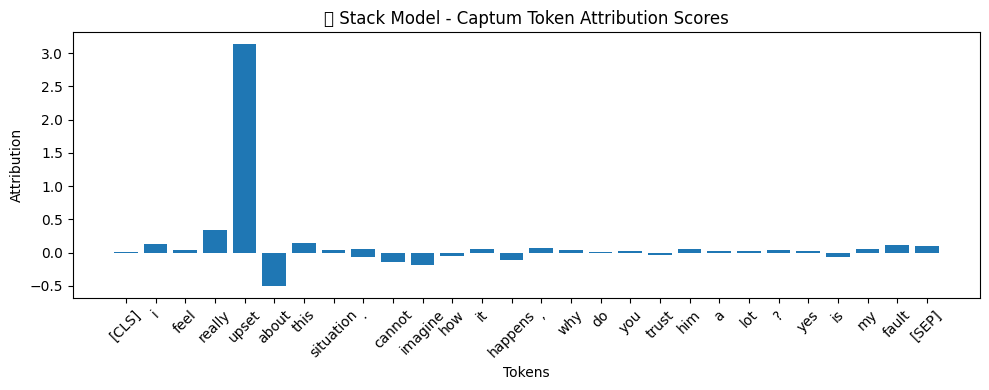

In [45]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer, pipeline
from captum.attr import IntegratedGradients
from IPython.display import display, HTML

# -------- Load Base Model --------
class CustomBERTModel(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size + 1, num_labels)

    def forward(self, input_ids, attention_mask, sentiment_score):
        pooled = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0]
        sentiment_score = sentiment_score.unsqueeze(1)
        combined = torch.cat((pooled, sentiment_score), dim=1)
        combined = self.dropout(combined)
        return self.classifier(combined)

# Base model paths
model_path = "/content/drive/MyDrive/saved_models/finegrained_stack_model"
num_labels = 12

# Label mapping for stack model (update if your actual mapping differs)
label_mapping = {
    0: 'afraid', 1: 'angry', 2: 'anticipating', 3: 'ashamed',
    4: 'devastated', 5: 'excited', 6: 'furious', 7: 'guilty',
    8: 'nostalgic', 9: 'sad', 10: 'sentimental', 11: 'terrified'
}


# Load base model
model = CustomBERTModel("bert-base-uncased", num_labels)
model.load_state_dict(torch.load(f"{model_path}/pytorch_model.bin", map_location="cpu"))
model.eval()

tokenizer = AutoTokenizer.from_pretrained(model_path)

# Emotion classifier for sentiment score
emotion_classifier = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    truncation=True,
    max_length=512,
    top_k=None
)

def get_emotion_score(text):
    result = emotion_classifier(text)
    if isinstance(result, list) and isinstance(result[0], list):
        result = result[0]
    max_prob = max([r['score'] for r in result])
    return round(max_prob * 10, 2)

# Wrapper for embeddings
class ForwardFuncWithEmbeddings(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, embeddings, attention_mask, sentiment_score):
        pooled = self.model.bert(inputs_embeds=embeddings, attention_mask=attention_mask).last_hidden_state[:, 0]
        if sentiment_score.dim() == 1:
            sentiment_score = sentiment_score.unsqueeze(1)
        sentiment_score = sentiment_score.expand(embeddings.size(0), 1)
        combined = torch.cat((pooled, sentiment_score), dim=1)
        combined = self.model.dropout(combined)
        return self.model.classifier(combined)

# -------- Example Input --------
text = "i feel really upset about this situation. i cannot imagine how it happens, Why do you trust him a lot? Yes. It is my fault."

# Get sentiment score
score = get_emotion_score(text)
sentiment_score = torch.tensor([score], dtype=torch.float)

# Tokenize
inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=96)
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

# Predict label
with torch.no_grad():
    logits = model(input_ids, attention_mask, sentiment_score)
predicted_label = torch.argmax(logits, dim=1).item()

# Map predicted label to emotion name
predicted_emotion = label_mapping.get(predicted_label, "Unknown")
#print(f"🎯 Predicted Emotion: {predicted_emotion}")


from IPython.display import display, Markdown
def print_highlighted_emotion(predicted_emotion):
    display(Markdown(f"<span style='font-size:22px; font-weight: bold; color: darkred;'>🎯 **Predicted Emotion:** `{predicted_emotion.upper()}`</span>"))

# Assuming predicted_emotion is the string like "sad" or "angry"
display(Markdown(f"### 🎯 **Predicted Emotion:** <span style='font-size:24px; color:darkred;'>**{predicted_emotion.upper()}**</span>"))




# Captum
embeddings = model.bert.embeddings(input_ids)
wrapper = ForwardFuncWithEmbeddings(model)
ig = IntegratedGradients(wrapper)

attributions, _ = ig.attribute(
    embeddings,
    additional_forward_args=(attention_mask, sentiment_score),
    target=predicted_label,
    n_steps=20,
    return_convergence_delta=True
)

# Visualize
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
scores = attributions.sum(dim=2).squeeze(0)

# Filter out [PAD]
filtered_tokens = []
filtered_scores = []
for tok, s in zip(tokens, scores):
    if tok != "[PAD]":
        filtered_tokens.append(tok.replace("##", ""))
        filtered_scores.append(s.item())

# Bar chart
plt.figure(figsize=(10, 4))
plt.bar(filtered_tokens, filtered_scores)
plt.title("📊 Stack Model - Captum Token Attribution Scores")
plt.xlabel("Tokens")
plt.ylabel("Attribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Inline color-highlighted tokens
highlighted = ""
for token, score in zip(filtered_tokens, filtered_scores):
    norm_score = (score + 1) / 2  # Normalize [-1,1] -> [0,1]
    color = f"rgba(255, 165, 0, {norm_score})"
    highlighted += f"<span style='background-color:{color}; padding:2px; margin:1px'>{token} </span>"

display(HTML(f"<div style='font-family:monospace'>{highlighted}</div>"))


In [1]:
import torch
import os
from transformers import AutoTokenizer, AutoModel, pipeline
import torch.nn as nn

# Load emotion classifier for sentiment score prediction
emotion_classifier = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    truncation=True,
    max_length=512,
    top_k=None  # Return all emotion scores
)

# Function to predict sentiment score
def get_emotion_score(text):
    predictions = emotion_classifier(text)[0]
    max_prob = max([pred['score'] for pred in predictions])  # Highest emotion probability
    return round(max_prob * 10, 2)  # Normalize score to scale of 0-10

# Custom BERT Model Definition
class CustomBERTModel(nn.Module):
    def __init__(self, model_name, num_labels):
        super(CustomBERTModel, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        hidden_size = self.bert.config.hidden_size  # usually 768
        additional_feature_size = 1  # sentiment_score is a scalar
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(hidden_size + additional_feature_size, num_labels)

    def forward(self, input_ids, attention_mask, sentiment_score):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # Get [CLS] representation
        sentiment_score = sentiment_score.unsqueeze(1)  # Reshape to (batch_size, 1)
        combined = torch.cat((pooled_output, sentiment_score), dim=1)
        combined = self.dropout(combined)
        logits = self.classifier(combined)
        return logits

# Emotion Categories
emotion_base_model = ['afraid', 'angry', 'annoyed', 'anticipating', 'anxious', 'apprehensive', 'ashamed', 'caring', 'confident', 'content', 'devastated', 'disappointed', 'disgusted', 'embarrassed', 'excited', 'faithful', 'furious', 'grateful', 'guilty', 'hopeful', 'impressed', 'jealous', 'joyful', 'lonely', 'nostalgic', 'prepared', 'proud', 'sad', 'sentimental', 'surprised', 'terrified', 'trusting']
emotion_misclassified = ['afraid', 'angry', 'anticipating', 'ashamed', 'devastated', 'excited', 'furious', 'guilty', 'nostalgic', 'sad', 'sentimental', 'terrified']

# Load Base Model
base_model_path = '/content/drive/MyDrive/saved_models/finegrained_base_model'
base_num_labels = 32
base_model = CustomBERTModel('bert-base-uncased', base_num_labels)
base_model.load_state_dict(torch.load(os.path.join(base_model_path, "pytorch_model.bin"), map_location=torch.device('cpu')))
base_model.eval()

# Load Secondary Model
secondary_model_path = '/content/drive/MyDrive/saved_models/finegrained_stack_model'
secondary_num_labels = 12
secondary_model = CustomBERTModel('bert-base-uncased', secondary_num_labels)
secondary_model.load_state_dict(torch.load(os.path.join(secondary_model_path, "pytorch_model.bin"), map_location=torch.device('cpu')))
secondary_model.eval()

# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Label Mappings
base_label_mapping = {'afraid': 0, 'angry': 1, 'annoyed': 2, 'anticipating': 3, 'anxious': 4, 'apprehensive': 5, 'ashamed': 6, 'caring': 7, 'confident': 8, 'content': 9, 'devastated': 10, 'disappointed': 11, 'disgusted': 12, 'embarrassed': 13, 'excited': 14, 'faithful': 15, 'furious': 16, 'grateful': 17, 'guilty': 18, 'hopeful': 19, 'impressed': 20, 'jealous': 21, 'joyful': 22, 'lonely': 23, 'nostalgic': 24, 'prepared': 25, 'proud': 26, 'sad': 27, 'sentimental': 28, 'surprised': 29, 'terrified': 30, 'trusting': 31}
secondary_label_mapping = {'afraid': 0, 'angry': 1, 'anticipating': 2, 'ashamed': 3, 'devastated': 4, 'excited': 5, 'furious': 6, 'guilty': 7, 'nostalgic': 8, 'sad': 9, 'sentimental': 10, 'terrified': 11}
base_label_mapping_inverse = {v: k for k, v in base_label_mapping.items()}
secondary_label_mapping_inverse = {v: k for k, v in secondary_label_mapping.items()}

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model.to(device)
secondary_model.to(device)

# Emotion Prediction Function
def predict_emotion(text):
    # Tokenize input
    inputs = tokenizer(text, return_tensors="pt", padding='max_length', truncation=True, max_length=96)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Predict sentiment score
    sentiment_score_value = get_emotion_score(text)
    sentiment_score_tensor = torch.tensor([sentiment_score_value]).to(device)

    print(f"Sentiment Score: {sentiment_score_value}")  # Print sentiment score

    # Base Model Prediction
    with torch.no_grad():
        logits = base_model(inputs["input_ids"], inputs["attention_mask"], sentiment_score_tensor)
    base_predicted_label = torch.argmax(logits, dim=1).item()
    base_predicted_emotion = base_label_mapping_inverse[base_predicted_label]

    # If the base prediction is not in misclassified emotions, return the result
    if base_predicted_emotion not in emotion_misclassified:
        print(f"🔍 Base Model Prediction: {base_predicted_emotion} (Sentiment Score: {sentiment_score_value})")
        return base_predicted_emotion, sentiment_score_value

    # If the base prediction is in the misclassified list, use the secondary model
    with torch.no_grad():
        logits = secondary_model(inputs["input_ids"], inputs["attention_mask"], sentiment_score_tensor)
    secondary_predicted_label = torch.argmax(logits, dim=1).item()
    secondary_predicted_emotion = secondary_label_mapping_inverse[secondary_predicted_label]

    print(f"🔁 Secondary Model Prediction: {secondary_predicted_emotion} (Sentiment Score: {sentiment_score_value})")
    return secondary_predicted_emotion, sentiment_score_value

# Example Inference
#example_text = "I am feeling really devastated after hearing that news."

example_text = [
    "I don't know how Mr. Peter buy such a large TV. Soo big too much for him, Yes I think such big TV is not suitale for him, He is only very poor guy"

]
predicted_emotion, sentiment_score = predict_emotion(example_text)
print(f"Final Prediction: {predicted_emotion} (Sentiment Score: {sentiment_score})")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cpu


Sentiment Score: 7.27
🔍 Base Model Prediction: jealous (Sentiment Score: 7.27)
Final Prediction: jealous (Sentiment Score: 7.27)


In [2]:
!pip install streamlit
!pip install pyngrok


In [3]:
!ngrok config add-authtoken 2vJXA9WS7U1sraD746aQOnmNRMI_7JFX1YHRHMd29pHFbW2Ki


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [4]:
!pip install streamlit captum transformers torch matplotlib

In [5]:
%%writefile app.py
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel, pipeline
from captum.attr import IntegratedGradients
import streamlit as st

# ——————— 1) Paths & Label Maps ——————————————————————
BASE_PATH  = "/content/drive/MyDrive/saved_models/finegrained_base_model"
STACK_PATH = "/content/drive/MyDrive/saved_models/finegrained_stack_model"

BASE_LABELS  = {'afraid': 0, 'angry': 1, 'annoyed': 2, 'anticipating': 3, 'anxious': 4, 'apprehensive': 5, 'ashamed': 6, 'caring': 7, 'confident': 8, 'content': 9, 'devastated': 10, 'disappointed': 11, 'disgusted': 12, 'embarrassed': 13, 'excited': 14, 'faithful': 15, 'furious': 16, 'grateful': 17, 'guilty': 18, 'hopeful': 19, 'impressed': 20, 'jealous': 21, 'joyful': 22, 'lonely': 23, 'nostalgic': 24, 'prepared': 25, 'proud': 26, 'sad': 27, 'sentimental': 28, 'surprised': 29, 'terrified': 30, 'trusting': 31}
STACK_LABELS = {'afraid': 0, 'angry': 1, 'anticipating': 2, 'ashamed': 3, 'devastated': 4, 'excited': 5, 'furious': 6, 'guilty': 7, 'nostalgic': 8, 'sad': 9, 'sentimental': 10, 'terrified': 11}

BASE_INV   = {v: k for k, v in BASE_LABELS.items()}
STACK_INV  = {v: k for k, v in STACK_LABELS.items()}

MISCLASS   = {'afraid', 'angry', 'anticipating', 'ashamed', 'devastated', 'excited', 'furious', 'guilty', 'nostalgic', 'sad', 'sentimental', 'terrified'}

# ——————— 2) Sentiment‑Scoring Pipeline —————————————————
emotion_classifier = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    truncation=True, max_length=512, top_k=None,
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased'),
    device =-1

)

def get_emotion_score(text: str) -> float:
    preds = emotion_classifier(text)[0]
    return round(max(p["score"] for p in preds) * 10, 2)

# ——————— 3) Model & Tokenizer Loader ——————————————————
class CustomBERTModel(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size + 1, num_labels)

    def forward(self, input_ids, attention_mask, sentiment_score):
        pooled = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        ).last_hidden_state[:, 0]
        s = sentiment_score.unsqueeze(1)
        x = torch.cat([pooled, s], dim=1)
        return self.classifier(self.dropout(x))

# Load base model
base_model = CustomBERTModel("bert-base-uncased", num_labels=32)
base_model.load_state_dict(torch.load(
    os.path.join(BASE_PATH, "pytorch_model.bin"),
    map_location="cpu"
))
base_model.eval()
base_tok = AutoTokenizer.from_pretrained(BASE_PATH)

# Load stack model
stack_model = CustomBERTModel("bert-base-uncased", num_labels=12)
stack_model.load_state_dict(torch.load(
    os.path.join(STACK_PATH, "pytorch_model.bin"),
    map_location="cpu"
))
stack_model.eval()
stack_tok = AutoTokenizer.from_pretrained(STACK_PATH)

# ——————— 4) Captum Wrapper & Explainer —————————————
class ForwardWithEmbeds(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, embeddings, attention_mask, sentiment_score):
        pooled = self.model.bert(
            inputs_embeds=embeddings,
            attention_mask=attention_mask
        ).last_hidden_state[:, 0]
        if sentiment_score.dim() == 1:
            sentiment_score = sentiment_score.unsqueeze(1)
        s = sentiment_score.expand(pooled.size(0), 1)
        x = torch.cat([pooled, s], dim=1)
        return self.model.classifier(self.model.dropout(x))


from captum.attr import IntegratedGradients

def show_attributions(model, tokenizer, text, pred_label, sentiment_score):
    # Tokenize
    toks = tokenizer(
        text,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=96,
    )
    ids, mask = toks["input_ids"], toks["attention_mask"]
    embeds = model.bert.embeddings(ids)

    # Captum wrapper
    wrapper = ForwardWithEmbeds(model)
    ig      = IntegratedGradients(wrapper)

    # Only one return value now
    atts = ig.attribute(
        embeds,
        additional_forward_args=(mask, sentiment_score),
        target=pred_label,
        n_steps=20,
        return_convergence_delta=False,
    )

    # Sum across embedding dim
    scores = atts.sum(dim=2).squeeze(0)
    tokens = tokenizer.convert_ids_to_tokens(ids[0])

    # Filter out [PAD]
    f_tokens, f_scores = [], []
    for t, s in zip(tokens, scores):
        if t != "[PAD]":
            f_tokens.append(t.replace("##", ""))
            f_scores.append(s.item())

    # Bar chart
    import matplotlib.pyplot as plt
    import streamlit as st

    fig, ax = plt.subplots(figsize=(8,3))
    ax.bar(f_tokens, f_scores)
    ax.set_xticklabels(f_tokens, rotation=45, ha="right")
    ax.set_title("Integrated Gradients Token Attribution")
    st.pyplot(fig)

    # Inline highlight
    hl = ""
    for t, s in zip(f_tokens, f_scores):
        norm = (s + 1)/2
        color = f"rgba(255,165,0,{norm:.2f})"
        hl += f"<span style='background:{color}; padding:2px'>{t}</span> "
    st.markdown(hl, unsafe_allow_html=True)




# ——————— 5) Streamlit UI ——————————————————————
st.title("🎭 Emotion Classification + Explainability")

user_input = st.text_area("Enter conversation:", "")

if st.button("Predict & Explain"):
    if not user_input.strip():
        st.warning("Please type some text!")
    else:
        # 1) sentiment
        score = get_emotion_score(user_input)
        st.write(f"**Sentiment Score**: {score} / 10")

        # 2) base inference
        b = base_tok(
            user_input,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=96
        )
        s_t = torch.tensor([score], dtype=torch.float)
        with torch.no_grad():
            logits = base_model(b["input_ids"], b["attention_mask"], s_t)
        b_pred = torch.argmax(logits, dim=1).item()
        b_em   = BASE_INV[b_pred]

        # 3) cascade if needed
        if b_em in MISCLASS:
            st.write(f"⚠️ Base predicted **{b_em}**, running fine‑grained model…")
            x = stack_tok(
                user_input,
                return_tensors="pt",
                padding="max_length",
                truncation=True,
                max_length=96
            )
            with torch.no_grad():
                l2 = stack_model(x["input_ids"], x["attention_mask"], s_t)
            s_pred = torch.argmax(l2, dim=1).item()
            final = STACK_INV[s_pred]
            st.success(f"### 🎯 Final Emotion: **{final.upper()}**")
            show_attributions(stack_model, stack_tok, user_input, s_pred, s_t)
        else:
            st.success(f"### 🎯 Final Emotion: **{b_em.upper()}**")
            show_attributions(base_model, base_tok, user_input, b_pred, s_t)


Overwriting app.py


In [6]:

!streamlit run app.py &>/content/streamlit.log&


In [7]:
from pyngrok import ngrok

# Start Streamlit app in background
!streamlit run app.py &> streamlit_log.txt &

# Create public URL with correct protocol and port
public_url = ngrok.connect(addr=8501, proto="http")

# Display the URL
print(f"🌐 Public URL: {public_url}")


🌐 Public URL: NgrokTunnel: "https://1867-34-145-244-19.ngrok-free.app" -> "http://localhost:8501"


In [60]:
from pyngrok import ngrok
ngrok.kill()  # This stops all active tunnels in the current session
